In [1]:
import os
import re
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from visturing.properties.prop6 import load_data, load_ground_truth
from visturing.ranking import prepare_data, calculate_correlations_with_ground_truth, calculate_correlations, prepare_and_correlate, prepare_and_correlate_order, calculate_spearman, calculate_pearson_stack

In [3]:
x_gt, y_gt, rg_gt, yb_gt = load_ground_truth("../../ground_truth_decalogo")

In [4]:
root_path = "../../Data/Experiment_6_7"

In [5]:
data = {re.findall("noise_(\w+)\.", p)[0]: np.load(p) for p in glob(os.path.join(root_path, "*")) if "gabor" in p}
for k, v in data.items(): print(k, v.shape)

achrom (5, 21, 256, 256, 3)
red_green (5, 21, 256, 256, 3)
yellow_blue (5, 21, 256, 256, 3)


In [6]:
freqs = np.array([1.5, 3, 6, 12, 24])
freqs

array([ 1.5,  3. ,  6. , 12. , 24. ])

In [7]:
# for name, chroma in data.items():
#     for dat in chroma:
#         fig, axes = plt.subplots(1,len(dat))
#         for ax, d in zip(axes.ravel(), dat):
#             ax.imshow(d)
#             ax.axis("off")
#         plt.show()

In [8]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import PerceptNet
from paramperceptnet.configs import param_config

In [9]:
model_name = "ppnet-bio-fitted"

In [10]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [11]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
state = variables["state"]
params = variables["params"]

In [12]:
model = PerceptNet(config)

In [13]:
params.keys()

dict_keys(['CenterSurroundLogSigmaK_0', 'Color', 'GDNGamma_0', 'GDNGaussian_0', 'GDNSpatioChromaFreqOrient_0', 'GDN_0', 'GaborLayerGammaHumanLike__0', 'LinearScaling_0'])

In [14]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0][...,0:64]
    b = extra_b["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0][...,0:64]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [15]:
diffs = defaultdict(dict)
for name, chroma in data.items():
    if name != "achrom": continue
    for f, dat in zip(freqs, chroma):
        diffs_ = calculate_diffs(dat, dat[0:1])
        diffs[name][f] = diffs_

In [16]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0][...,64:96]
    b = extra_b["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0][...,64:96]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [17]:
# diffs = defaultdict(dict)
for name, chroma in data.items():
    if name != "red_green": continue
    for f, dat in zip(freqs, chroma):
        diffs_ = calculate_diffs(dat, dat[0:1])
        diffs[name][f] = diffs_

In [18]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0][...,96:]
    b = extra_b["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0][...,96:]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [19]:
# diffs = defaultdict(dict)
for name, chroma in data.items():
    if name != "yellow_blue": continue
    for f, dat in zip(freqs, chroma):
        diffs_ = calculate_diffs(dat, dat[0:1])
        diffs[name][f] = diffs_

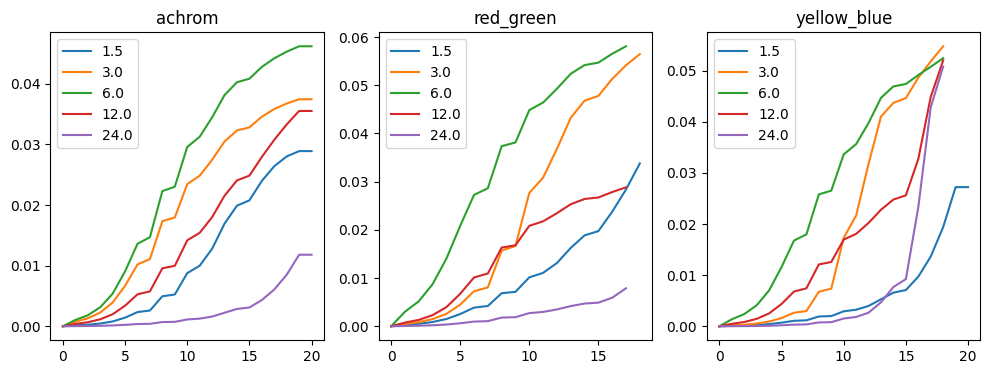

In [20]:
fig, axes = plt.subplots(1,len(diffs), figsize=(12,4))
for (name, chroma), ax in zip(diffs.items(), axes.ravel()):
    for f, dat in chroma.items():
        ax.plot(dat, label=f)
    ax.legend()
    ax.set_title(name)
plt.show()

In [21]:
x_a, x_rg, x_yb = load_data("../../Data/Experiment_6_7")
x_a.shape, x_rg.shape, x_yb.shape

((21,), (21,), (21,))

In [22]:
diffs_a = np.array([a for a in diffs["achrom"].values()])
diffs_rg = np.array([a for a in diffs["red_green"].values()])
diffs_yb = np.array([a for a in diffs["yellow_blue"].values()])
diffs_a.shape, diffs_rg.shape, diffs_yb.shape

((5, 21), (5, 21), (5, 21))

In [23]:
x_gt.shape, y_gt.shape, rg_gt.shape, yb_gt.shape

((55,), (5, 55), (5, 55), (5, 55))

In [24]:
bs, ds = [], []
for b, d in zip(diffs_a, y_gt):
    a, b, c, d = prepare_data(x_a, b, x_gt, d)
    bs.append(b)
    ds.append(d)
b_a = np.array(bs)
d_a = np.array(ds)
b_a.shape, d_a.shape

((5, 55), (5, 55))

In [25]:
calculate_correlations_with_ground_truth(b_a, d_a)

{'spearman': np.float64(0.8727272727272727),
 'kendall': np.float64(0.8472727272727272),
 'pearson': np.float64(0.8727272727272726)}

In [26]:
bs, ds = [], []
for b, d in zip(diffs_rg, rg_gt):
    a, b, c, d = prepare_data(x_rg, b, x_gt, d)
    bs.append(b)
    ds.append(d)
b_rg = np.array(bs)
d_rg = np.array(ds)
b_rg.shape, d_rg.shape

((5, 55), (5, 55))

In [27]:
calculate_correlations_with_ground_truth(b_rg, d_rg)

{'spearman': np.float64(0.4072727272727273),
 'kendall': np.float64(0.3077355371900826),
 'pearson': np.float64(0.4072727272727272)}

In [28]:
bs, ds = [], []
for b, d in zip(diffs_yb, yb_gt):
    a, b, c, d = prepare_data(x_yb, b, x_gt, d)
    bs.append(b)
    ds.append(d)
b_yb = np.array(bs)
d_yb = np.array(ds)
b_yb.shape, d_yb.shape

((5, 55), (5, 55))

In [29]:
calculate_correlations_with_ground_truth(b_yb, d_yb)

{'spearman': np.float64(0.20545454545454545),
 'kendall': np.float64(0.18152066115702478),
 'pearson': np.float64(0.2054545454545454)}

In [30]:
import scipy.stats as stats
b_cat = np.concatenate([
        b_a.ravel(), b_rg.ravel(), b_yb.ravel(),
    ])
nan_mask = np.isnan(b_cat)
d_cat = np.concatenate([
        d_a.ravel(), d_rg.ravel(), d_yb.ravel(),
    ])
stats.pearsonr(
    b_cat[~nan_mask], d_cat[~nan_mask]
)

PearsonRResult(statistic=np.float64(0.6150544819878316), pvalue=np.float64(7.167165487630534e-80))